In [6]:
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import Image, HTML 
from PIL import Image, ImageDraw

import sys
import os

sys.path.append(os.path.join('D:/', 'Max', 'python', 'randimg'))

import itertools
import ImgGenerator

tf.keras.backend.clear_session()  # For easy reset of notebook state.
# inputs = keras.Input(shape=(256, 50, 2)) # I have 40 picture for them 2 reduces each 256*50 size

interlaced_reduce_input = keras.Input(shape=( ImgGenerator.W, ImgGenerator.H, 1), name='interlaced_reduce')
print(interlaced_reduce_input.shape)
small_conv = layers.Conv2D(32, (3, 2), padding="same", activation='relu')(interlaced_reduce_input)
small_conv = layers.LeakyReLU()(small_conv)
print(small_conv.shape)
medium_conv = layers.Conv2D(64, (3, 2), padding="same", activation='relu')(small_conv)
medium_conv = layers.LeakyReLU()(medium_conv)
print(medium_conv.shape)
large_conv = layers.Conv2D(128, (3, 2), padding="same", activation='relu')(medium_conv)
large_conv = layers.LeakyReLU()(large_conv)
print(large_conv.shape)
#
def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during upsampling"""
    u = layers.UpSampling2D(size=2)(layer_input)
    u = layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
        u = layers.Dropout(dropout_rate)(u)
    u = layers.BatchNormalization(momentum=0.8)(u)
    u = layers.Concatenate()([u, skip_input])
    return u
# Upsampling
#u1 = deconv2d(large_conv, medium_conv, 64)
#u2 = deconv2d(u1, small_conv, 32)
#u3 = UpSampling2D(size=2)(u2)
#output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u3)
u = layers.BatchNormalization(momentum=0.8)(large_conv)
output_img = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u)
print(output_img.shape)


(None, 128, 128, 1)
(None, 128, 128, 32)
(None, 128, 128, 64)
(None, 128, 128, 128)
(None, 128, 128, 1)


In [7]:

model = keras.Model(inputs=interlaced_reduce_input, outputs=output_img)
#model = keras.Model(inputs=x, outputs=output)
model.summary()
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
interlaced_reduce (InputLaye [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      12352     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     49280     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 128)     0     

Train: reduced-shape:(64, 128, 128)


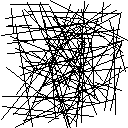

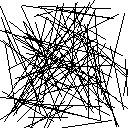

Train: y-shape:(64, 128, 128)


In [8]:
interlaced_reduce = []
train_y = []

# make train set
for a, b, y in itertools.islice(ImgGenerator.produce_numpy_sample(), 0, 64):
    # interlaced makes from 2 matrix: [[x1, x2], [x3, x4]] & [[y1, y2] [y3, y4]]
    #    forms rows side-by-side:     [[x1, x2], [y1, y2], [x3, x4], [y3, y4]]
    interlaced = np.hstack((a, b)).reshape(ImgGenerator.H, ImgGenerator.W)
    interlaced_reduce.append(interlaced)
    train_y.append(y)

interlaced_reduce = np.stack(interlaced_reduce) #convert list to matrix

print(f'Train: reduced-shape:{interlaced_reduce.shape}')

#train_x = {"interlaced_reduce": interlaced_reduce}
train_y = np.stack(train_y) # convert from list to np.array

iy = Image.fromarray((train_y[1,:,:]*255).astype(np.int8), 'L')
display(iy)
iy = Image.fromarray((train_y[2,:,:]*255).astype(np.int8), 'L')
display(iy)
print(f'Train: y-shape:{train_y.shape}')


In [9]:

"""
#train_x = np.random.randint(0, high=10, size=(32, 128, 128, 1))
train_x = {"top_reduce": np.random.randint(0, high=10, size=(32, 128, 64, 1)),
           "left_reduce": np.random.randint(0, high=10, size=(32, 128, 64, 1))}
train_y = np.random.randint(0, high=1, size=(32, 128, 128, 1))
"""
history = model.fit(x = interlaced_reduce, y=train_y, epochs=10)


Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 0.2504 - mae: 0.4993
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 0.2464 - mae: 0.4955
Epoch 3/50
2/2 [==============================] - 6s 3s/step - loss: 0.2419 - mae: 0.4908
Epoch 4/50
2/2 [==============================] - 6s 3s/step - loss: 0.2375 - mae: 0.4855
Epoch 5/50
2/2 [==============================] - 6s 3s/step - loss: 0.2317 - mae: 0.4786
Epoch 6/50
2/2 [==============================] - 6s 3s/step - loss: 0.2258 - mae: 0.4704
Epoch 7/50
2/2 [==============================] - 5s 3s/step - loss: 0.2193 - mae: 0.4602
Epoch 8/50
2/2 [==============================] - 5s 3s/step - loss: 0.2132 - mae: 0.4489
Epoch 9/50
2/2 [==============================] - 6s 3s/step - loss: 0.2080 - mae: 0.4364
Epoch 10/50
2/2 [==============================] - 6s 3s/step - loss: 0.2044 - mae: 0.4231
Epoch 11/50
2/2 [==============================] - 6s 3s/step - loss: 0.2025 - mae: 0.4107
Epoch 12

In [10]:
#
# model evaluation
test_reduces = []
test_y = []

# make test set
for a, b, y in itertools.islice(ImgGenerator.produce_numpy_sample(), 0, 32):
    interlaced = np.hstack((a, b)).reshape(ImgGenerator.H, ImgGenerator.W)
    test_reduces.append(interlaced)
    test_y.append(y)

test_reduces = np.stack(test_reduces)

print(f'Test: test_reduces-shape:{test_reduces.shape}')

test_y = np.stack(test_y) # convert from list to np.array

print(f'Test: y-shape:{test_y.shape}')

test_scores = model.evaluate(test_reduces, test_y, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


Test: test_reduces-shape:(32, 128, 128)
Test: y-shape:(32, 128, 128)
1/1 - 0s - loss: 0.2011 - mae: 0.3879
Test loss: 0.20111222565174103
Test accuracy: 0.3878994584083557


In [12]:
target_y, predict_in = zip(
    *[(y, np.hstack((a, b)).reshape(ImgGenerator.H, ImgGenerator.W))
                       for a, b, y in itertools.islice(ImgGenerator.produce_numpy_sample(), 0,4)] )
predict_in = np.stack(predict_in)
prediction = model.predict(predict_in)
print(prediction.shape)
print(prediction[0])

(4, 128, 128, 1)
[[[0.9678314 ]
  [0.98672915]
  [0.98672915]
  ...
  [0.9999286 ]
  [0.9994218 ]
  [0.9978396 ]]

 [[0.98061633]
  [0.9929272 ]
  [0.9929272 ]
  ...
  [0.99999726]
  [0.99995846]
  [0.9997722 ]]

 [[0.8389154 ]
  [0.8773763 ]
  [0.8773763 ]
  ...
  [0.99997497]
  [0.9999038 ]
  [0.99964   ]]

 ...

 [[0.976346  ]
  [0.99088   ]
  [0.99088   ]
  ...
  [0.9999857 ]
  [0.99981964]
  [0.99947894]]

 [[0.9574828 ]
  [0.97678876]
  [0.97678876]
  ...
  [0.999847  ]
  [0.9988641 ]
  [0.9950282 ]]

 [[0.95074314]
  [0.975103  ]
  [0.975103  ]
  ...
  [0.99908066]
  [0.9937711 ]
  [0.9880934 ]]]


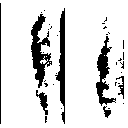

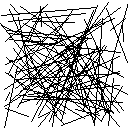

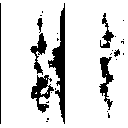

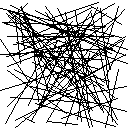

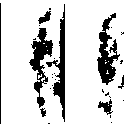

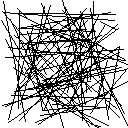

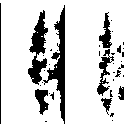

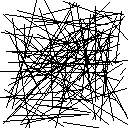

In [13]:
ix = Image.fromarray((test_y[0,:,:]*255).astype(np.int8), 'L') 
for v, y in zip(prediction, target_y):
    v1 = np.reshape(v, (1, ImgGenerator.W, ImgGenerator.H))
    av = v1[0,:,:] > 0.7
    iy = Image.fromarray((y*255).astype(np.int8), 'L')
    ix = Image.fromarray((av.astype(np.int)*255).astype(np.int8), 'L')
    display(ix)
    display(iy)

[[0.5415723  0.5415723  0.5415723  ... 0.6308803  0.5820671  0.42561314]
 [0.70205677 0.70205677 0.70205677 ... 0.82271147 0.75100726 0.53188455]
 [0.71586037 0.71586037 0.71586037 ... 0.81169254 0.7347469  0.52586234]
 ...
 [0.71586037 0.71586037 0.71586037 ... 0.8356797  0.7830382  0.5624191 ]
 [0.69146496 0.69146496 0.69146496 ... 0.80689126 0.75651544 0.55274445]
 [0.5063544  0.5063544  0.5063544  ... 0.5808673  0.5515715  0.41736808]]


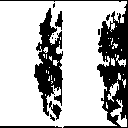

In [23]:
av = v1[0,:,:]
print(av)
av = av >0.7
iy = Image.fromarray((av.astype(np.int)*255).astype(np.int8), 'L')
display(iy)